# TVO pricing in the lognormal fSABR model

We consider the pricing problem of target volatility options (TVO) in the lognormal fractional SABR model. The pricing formulas implemented in this notebook were developed and proved in the paper [Alos et al. (2018)](https://arxiv.org/pdf/1801.08215.pdf) available on arXiv. We give here for completeness some useful theoretical results and definitions.

## 1. The fractional SABR model

The price of underlying asset $S_t$ and its instantaneous volatility $Y_t$ in the lognormal fSABR model are governed by the following SDE:


$$
\begin{array}{rcl}
\dfrac{dS_t}{S_t} &=& Y_t \left(\rho dB_t + \bar\rho dW_t\right), \\\cr
Y_t &=& Y_0 \exp\left(\nu B_t^H\right),
\end{array}
$$

where $B_t$ and $W_t$ are independent Brownian motions defined on the filtered probability space $(\Omega, \mathcal{F}_t, \mathbb Q)$ satisfying the usual conditions,  $\rho\in (-1,1)$ is the correlation, $\bar\rho := \sqrt{1 - \rho^2}$, and $B_t^H$ is the fractional Brownian motion driven by $B_t$. That is, 

$$
B_t^H = \int_0^t K(t,s) dB_s,
$$

where $K$ is the Molchan-Golosov kernel

$$
K(t,s) = c_H (t-s)^{H-\frac{1}{2}}{ }_2F_1\left(H-\frac{1}{2},\frac{1}{2}-H,H+\frac{1}{2};1-\frac{t}{s}\right)\mathbf{1}_{[0,t]}(s),
$$

with $c_H=\left[\frac{2H\Gamma\left(\frac{3}{2}-H\right)}{\Gamma(2-2H)\Gamma\left(H+\frac{1}{2}\right)}\right]^{1/2}$, ${ }_2F_1$ is the Gauss hypergeometric function, and $\Gamma$ is the Euler Gamma function.



For fixed $K > 0$, we define $X_t = \log\dfrac{S_t}K$. Then the fSABR model satisfies:

$$
\begin{array}{rcl}
dX_t &=& Y_t \left(\rho dB_t + \bar\rho dW_t\right) - \frac{1}{2} Y_t^2 dt = Y_t d\tilde W_t - \frac{1}{2} Y_t^2 dt, \\\cr
Y_t &=& Y_0 \exp\left(\nu B_t^H\right).
\end{array}
$$

## 2. Target volatility options (TVO)

A *target volatility* call struck at $K$  pays off at expiry $T$ the amount

$$
\dfrac{\bar\sigma}{\sqrt{\frac{1}{T}\int_0^T Y_t^2 dt}} \left( S_T - K \right)^+ = \dfrac{K \, \bar\sigma \sqrt T}{\sqrt{\int_0^T Y_t^2 dt}} \left( e^{X_T}- 1 \right)^+,
$$

where $\bar\sigma$ is the (preassigned) *target volatility* level. If at expiry the realized volatility is higher (lower) than the target volatility, the payoff is scale down (up) by the ratio between target volatility and realized volatility. For $t \leq T$, the price at time $t$ of a TV call struck at $K$ with expiry $T$ is hence given by the conditional expectation under the risk neutral probability $\mathbb Q$ as 

$$
K\, \bar\sigma \sqrt T \, 
\mathbb{E}\left[\left. \dfrac{1}{\sqrt{\int_0^T Y_\tau^2 d\tau}} \left( e^{X_T}- 1 \right)^+\right|\mathcal{F}_t\right]
$$

provided the expectation is finite.

## 3. TVO pricing

We employ for verification purposes three pricing methods: 

* Monte Carlo Simulations
* Decomposition Formula Approximation (DFA), see equation (4.7) in [Alos et al. (2018)](https://arxiv.org/pdf/1801.08215.pdf)
* Small Volatility of Volatility Expansion (SVVE), see equation (5.6) in [Alos et al. (2018)](https://arxiv.org/pdf/1801.08215.pdf)  

Observe that both formulas can be easily implemented numerically as they only require the use of special functions: the pdf $N'$ and cdf $N$ for a standard normal distribution, the Euler Gamma function $\Gamma$, the Gauss hypergeometric function ${ }_2F_1$, and the Beta function $\beta$.

### 3.1. Formula accuracy

To test the accuracy of DFA and SVVE, we produce sample paths for the lognormal fSABR price process and we use Monte Carlo techniques to calculate TVO prices. We first load the required modules, price via analytic formulas, and lastly we simulate sample paths for the fSABR process and use MC techniques for TVO pricing.

In [1]:
import numpy as np
import time 
import utils

from fSABR import fSABR
from scipy.integrate import trapz
from matplotlib import pyplot as plt
%matplotlib inline  

We consider the following values the parameters of the fSABR model and for the TVO contract:

In [2]:
T = 1.0
H = 0.1

nu = 0.05
S0 = 1.0
sig0 = 0.3 # Y0 in our notations
rho = -0.7

TV = 0.3
k = np.arange(-0.22, 0.22, 0.01)
K = np.exp(k)[np.newaxis,:]/S0

Pricing via DFA and SVVE:

In [3]:
""" TVO pricing via DFA (4.7) """
startTimer = time.time()
price1  = utils.tvoPrice_formulaAlternative_3(S0, sig0, K, T, TV, H, rho, nu)
endTimer = time.time()
t1 = endTimer - startTimer 


""" TVO pricing via SVVE (5.6) """
startTimer = time.time()
price2 = utils.tvoPrice_formula(S0, sig0, K, T, TV, H, rho, nu)
endTimer = time.time()
t2 = endTimer - startTimer

Pricing via Monte Carlo with $N=50,000$ paths and $n=1,000$ time steps:

In [16]:
""" TVO pricing via MC """
n = 1000
N = 50000
a = H - 0.5

fSV = fSABR(n, N, T, a)
dW1 = fSV.dW1()
dW2 = fSV.dW2()
dB = fSV.dB(dW1, dW2, rho)

WH  = fSV.WH(dW1)
sig = fSV.sig(WH, nu, sig0)
S = fSV.S(sig, dB, S0)


startTimer = time.time()
ST = S[:,-1][:,np.newaxis]
call_payoffs = np.maximum(ST - K,0)
RV = trapz(np.square(sig),fSV.t[0,:])[:,np.newaxis]/T
tvoCall_payoffs = TV * call_payoffs / np.sqrt(RV)
price3 = np.mean(tvoCall_payoffs, axis = 0)[:,np.newaxis]
endTimer = time.time()
t3 = endTimer - startTimer

Note that we used the following notations:
* price1 - Decomposition Formula Approx. (DFA)
* price2 - Small vol of vol expansion (SVVE)
* price3 - MC simulation

We plot the results and compare:

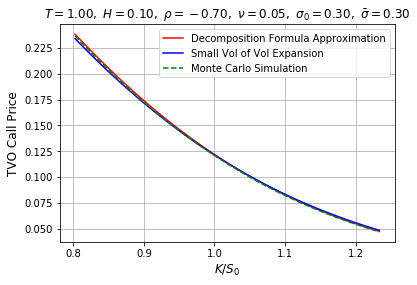

In [17]:
plot, axes = plt.subplots()
axes.plot(np.transpose(K), np.transpose(price1), 'r')
axes.plot(np.transpose(K), np.transpose(price2), 'b')
axes.plot(np.transpose(K), price3, 'g--')
axes.set_xlabel(r'$K/S_0$', fontsize=12)
axes.set_ylabel(r'TVO Call Price', fontsize=12)
axes.legend(['Decomposition Formula Approximation',
             'Small Vol of Vol Expansion','Monte Carlo Simulation'])
title = r'$T=%.2f,\ H=%.2f,\ \rho=%.2f,\ \nu=%.2f,\ \sigma_0=%.2f,\ \bar\sigma=%.2f$'
axes.set_title(title%(fSV.T, H, fSV.rho, fSV.nu, sig0 , TV), fontsize=12)
plt.grid(True)

We can note that the formulas are a good approximation for the actual (MC) price of the TVO. We calculate now the relative error between MC prices and DFA or SVVE.

In [18]:
# Concatenate arrays
err1 = np.divide(np.absolute(price3 - np.transpose(price1)), price3) * 100
err2 = np.divide(np.absolute(price3 - np.transpose(price2)), price3) * 100

tableTex = np.concatenate((np.transpose(K), price3), axis = 1)
tableTex = np.concatenate((tableTex, np.transpose(price1)), axis = 1)
tableTex = np.concatenate((tableTex, np.transpose(price2)), axis = 1)

tableTex = np.concatenate((tableTex, err1), axis = 1) 
tableTex = np.concatenate((tableTex, err2), axis = 1) 

In [19]:
import pandas as pd
df = pd.DataFrame(data=tableTex)
df.columns = ['K/S0', 'MC', 'DFA', 'SVVE', 'DFA rel.err.(%)', 'SVVE rel.err.(%)']
print(df)

        K/S0        MC       DFA      SVVE  DFA rel.err.(%)  SVVE rel.err.(%)
0   0.802519  0.236733  0.238463  0.234105         0.730918          1.110102
1   0.810584  0.230919  0.232631  0.228453         0.741292          1.068080
2   0.818731  0.225138  0.226830  0.222834         0.751433          1.023654
3   0.826959  0.219390  0.221063  0.217250         0.762683          0.975411
4   0.835270  0.213675  0.215332  0.211704         0.775477          0.922834
5   0.843665  0.208001  0.209642  0.206198         0.789114          0.866524
6   0.852144  0.202375  0.203994  0.200736         0.799982          0.809955
7   0.860708  0.196800  0.198393  0.195320         0.809069          0.752087
8   0.869358  0.191283  0.192840  0.189953         0.813728          0.695461
9   0.878095  0.185818  0.187339  0.184637         0.818319          0.635730
10  0.886920  0.180411  0.181893  0.179375         0.821176          0.574483
11  0.895834  0.175062  0.176504  0.174169         0.823604     

In [20]:
# Computing times
print('Computing times in seconds:')
print('SVEE = %.5f s; '%t1, 'DFA = %.5f s; '%t2, 'MC = %.5f s; '%t3)

Computing times in seconds:
SVEE = 0.00236 s;  DFA = 0.00457 s;  MC = 1.22972 s; 


### 3.2. Sensitivity to parameters

In order to stress test our formulas, we compute the TVO price at-the-money via the analytic formulas DFA, SVVE, and Monte Carlo simulations for a broad range of parameters $(H,\nu,\rho)$. Namely, we consider $H\in(0,0.5),\ \nu\in(0,0.6),$ and $\rho\in(-1,1)$. 

Firstly, we plot the TVO price as a function of 2 parameters while assuming the third being fixed. Secondly, we compute and plot the relative error between our formulas and prices via Monte Carlo trials. Note that the relative error is small, and that the price surfaces are fairly smooth. We emphasize that the approximation formulas turns out to be highly accurate and robust to parameter variations. 

We load our prices from a pkl file, which was produced using the script tvo_pricingSensitivity.py. We consider here SVVE formula - note that the code may be modified to account for DFA.

In [32]:
import pickle
from matplotlib import cm
import mpl_toolkits.mplot3d
from matplotlib.ticker import FormatStrFormatter


H   = np.arange(0.05,0.49,0.05) 
nu  = np.arange(0.01,0.61,0.01) 
rho = np.arange(-0.99,0.99,0.06)

with open('tvoCall_prices.pkl', 'rb') as f:
    tvo_MC, tvo_SVVE, tvo_DFA = pickle.load(f)
    
tvo_formula = tvo_SVVE # change to tvo_DFA for DFA analysis
tvoCall_prices = tvo_MC
errFormula = np.divide(tvoCall_prices - tvo_formula, tvoCall_prices)

In [40]:
print(tvo_MC.shape)

(9, 60, 33)


We keep the Hurst parameter $H$ fixed: 

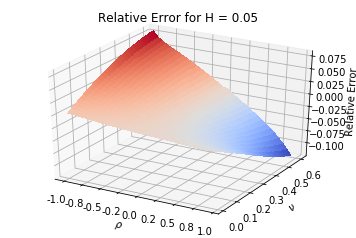

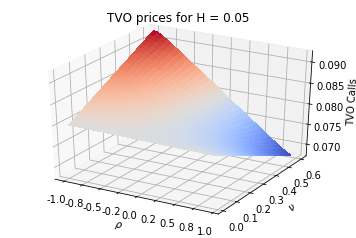

In [36]:
"""
Keeping H fixed
max(coefH) = 9
"""

coefH = 0
X, Y = np.meshgrid(rho,nu)
errFormulaH = errFormula[coefH,:,:]

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
surf = ax.plot_surface(X, Y, errFormulaH, cmap=cm.coolwarm, linewidth=0, 
                       antialiased=False)
title = r'Relative Error for H = %.2f'%H[coefH]
ax.set_title(title)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\nu$')
ax.set_zlabel('Relative Error')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
surf = ax.plot_surface(X, Y, tvo_formula[coefH,:,:], cmap=cm.coolwarm, 
                       linewidth=0, antialiased=False)
title = r'TVO prices for H = %.2f'%H[coefH]
ax.set_title(title)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\nu$')
ax.set_zlabel('TVO Calls');

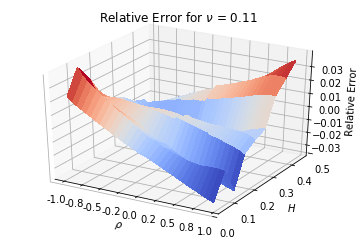

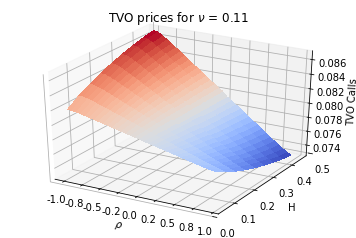

In [38]:
"""
Keeping \nu fixed
max(coefNu) = 60
"""

coefNu = 10
X, Y = np.meshgrid(rho,H)
errFormulaNu = errFormula[:,coefNu,:]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_ticks(np.arange(0, 0.55, 0.1))
surf = ax.plot_surface(X, Y, errFormulaNu, cmap=cm.coolwarm, 
                       linewidth=0, antialiased=False)
title = r'Relative Error for $\nu$ = %.2f'%nu[coefNu]
ax.set_title(title)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$H$')
ax.set_zlabel('Relative Error')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_ticks(np.arange(0, 0.55, 0.1))
surf = ax.plot_surface(X, Y, tvo_formula[:,coefNu,:], cmap=cm.coolwarm, 
                       linewidth=0, antialiased=False)
title = r'TVO prices for $\nu$ = %.2f'%nu[coefNu]
ax.set_title(title)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'H')
ax.set_zlabel('TVO Calls');

Text(0.5,0,'TVO Calls')

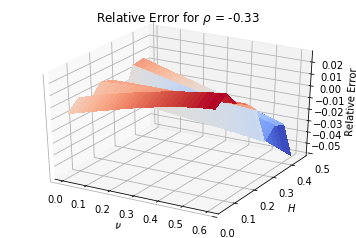

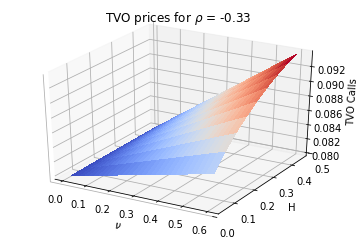

In [39]:
"""
Keeping \rho fixed
max(coefRho) = 33
"""

coefRho = 11
X, Y = np.meshgrid(nu,H)
errFormulaRho = errFormula[:,:,coefRho]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_ticks(np.arange(0, 0.55, 0.1))
surf = ax.plot_surface(X, Y, errFormulaRho, cmap=cm.coolwarm, linewidth=0, 
                       antialiased=False)
title = r'Relative Error for $\rho$ = %.2f'%rho[coefRho]
ax.set_title(title)
ax.set_xlabel(r'$\nu$')
ax.set_ylabel(r'$H$')
ax.set_zlabel('Relative Error')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_ticks(np.arange(0, 0.55, 0.1))
surf = ax.plot_surface(X, Y, tvo_formula[:,:,coefRho], cmap=cm.coolwarm, 
                       linewidth=0, antialiased=False)
title = r'TVO prices for $\rho$ = %.2f'%rho[coefRho]
ax.set_title(title)
ax.set_xlabel(r'$\nu$')
ax.set_ylabel(r'H')
ax.set_zlabel('TVO Calls')    

### 3.3. fSABR path generation

Sample paths for fractional Brownian Motions $\{ B^H(t_k),\ k=1,2,\dots,n\}$ using the Molchan--Golosov kernel are simulated. Here, we consider a partition 

$$\Pi:=\{0 = t_0<t_1<\cdots<t_n=T\}$$ 

of the interval $[0,T]$. We employ the hybrid scheme for Brownian semistationary processes given in the paper [Bennedsen et al. (2017)](https://arxiv.org/pdf/1507.03004.pdf), which is based on discretizing the stochastic integral representation of the process in the time domain, see also the code available on GitHub [here](https://github.com/ryanmccrickerd/rough_bergomi). 


Several test routines for fractional processes are also implemented: mean and variance as a function of time via Monte Carlo simulations, a chi-square test for fractional Gaussian noise, as well as the 2D correlation structure via sample paths. We notice that the sample paths have the required properties, that are specific to fBMs.

In [41]:
N = 50000
n = 1000
T = 1.0

H =  0.2
a = H - 0.5

rho  =  -0.7
nu   =  0.1
S0   =  1.0
sig0 =  0.2


""" fSABR process paths """
fSV = fSABR(n, N, T, a)

dW1 = fSV.dW1()
dW2 = fSV.dW2()
dB = fSV.dB(dW1, dW2, rho)

WH  = fSV.WH(dW1)
sig = fSV.sig(WH, nu, sig0)
S = fSV.S(sig, dB, S0)

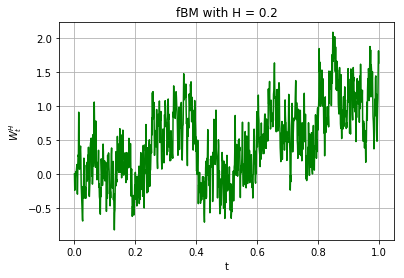

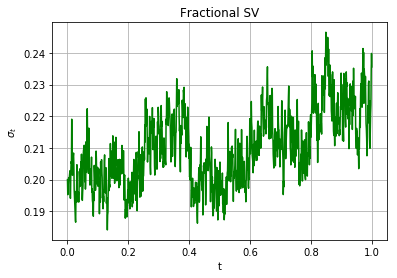

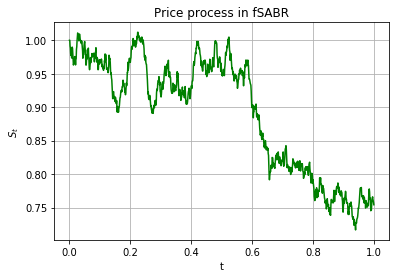

In [49]:
""" Plotting some sample paths """

plt.title('fBM with H = %.1f'%H)
plt.xlabel('t')
plt.ylabel('$W^H_t$')
plt.plot(fSV.t[0,:], WH[0,:], 'g')
plt.grid(True); plt.show()

plt.title('Fractional SV')
plt.xlabel('t')
plt.ylabel('$\sigma_t$')
plt.plot(fSV.t[0,:], sig[0,:], 'g')
plt.grid(True); plt.show()

plt.title('Price process in fSABR')
plt.xlabel('t')
plt.ylabel('$S_t$')
plt.plot(fSV.t[0,:], S[0,:], 'g')
plt.grid(True); plt.show(); 

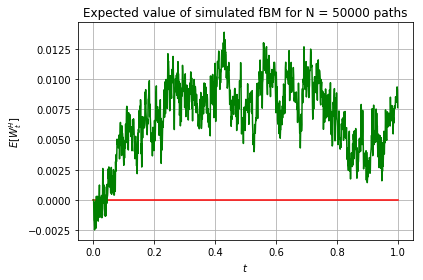

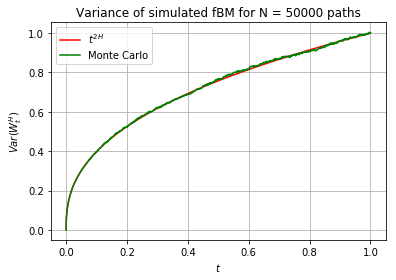

In [50]:
""" Check Statistical Properties of the fBM via MC """

eY1 = 0 * fSV.t                                         # Known expectation
vY1 = fSV.t**(2*fSV.a + 1)                              # Known variance
eY2 = np.mean(WH, axis=0, keepdims=True)                # Observed expectation
vY2 = np.var(WH, axis=0, keepdims=True)                 # Observed variance

plt.plot(fSV.t[0,:], eY1[0,:], 'r')
plt.plot(fSV.t[0,:], eY2[0,:], 'g') 
plt.xlabel(r'$t$')
plt.ylabel(r'$E[W^H_t]$')
plt.title(r'Expected value of simulated fBM for N = %d paths'%N)
plt.grid(True); plt.show()

plt.plot(fSV.t[0,:], vY1[0,:], 'r')
plt.plot(fSV.t[0,:], vY2[0,:], 'g') 
plt.xlabel(r'$t$')
plt.ylabel(r'$Var(W^H_t)$')
plt.title(r'Variance of simulated fBM for N = %d paths'%N)
plt.legend(['$t^{2H}$','Monte Carlo'])
plt.grid(True); plt.show()

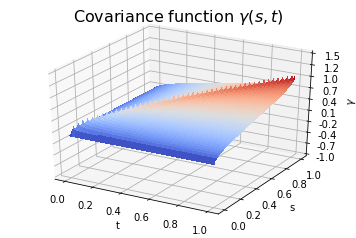

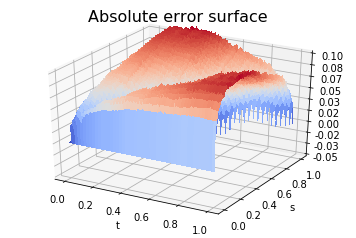

In [53]:
""" Check the 2D covariance structure of the simulated fBM via MC """

from matplotlib.ticker import LinearLocator

# Make the data
X, Y = np.meshgrid(fSV.t, fSV.t)
Z  = 0.5* (X**(2*H) + Y**(2*H) - (np.abs(X-Y))**(2*H))

# Compute covariance structure of simulated fBM via MC
Z2 = np.cov(WH, rowvar = False)

# Compute error
err = np.linalg.norm(Z-Z2)
errSurf = Z-Z2 

# Plot covariance surface for verification
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, 
                       antialiased=False)
ax.set_zlim(-1.01, 1.51)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
title = r'Covariance function $\gamma(s,t)$'
ax.set_title(title, fontsize=16)
ax.set_xlabel(r't')
ax.set_ylabel(r's')
ax.set_zlabel('$\gamma$')
plt.show()

# Plot error surface
fig = plt.figure()
ax = fig.gca(projection='3d')
surf3 = ax.plot_surface(X, Y, errSurf, 
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-0.05, 0.1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
title = r'Absolute error surface'
ax.set_title(title, fontsize=16)
ax.set_xlabel(r't')
ax.set_ylabel(r's')
plt.show()

In [55]:
""" 
Hypothesis testing
NULL hypotheses: 
    the covariances of the sample are in accordance with fractional 
    Gaussian noise for some specified Hurst parameter H

We use a chi-square test for fractional Gaussian noise
Test: reject NULL hypothesis when CN < chi2Test 
"""

import scipy as sp

XH = np.diff(WH)
Gam = [[utils.covGamma(i-j,H) for i in range(n)] for j in range(n)]
L  = np.linalg.cholesky(Gam)
ZH = (np.linalg.inv(L)).dot(np.transpose(XH))
CN = (np.linalg.norm(ZH, 2))**2         # Test statistic

alpha = 0.99                            # Confidence level
chi2Test = sp.stats.chi2.ppf(alpha,n)   # p value of the chi2Test
print('Reject null hypothesis: ', CN<chi2Test)

Reject null hypothesis:  False
